In [1]:
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

### Simulate the plant growth experiment again

In [2]:
np.random.seed(12)

n_plants = 100

# Simulate initial heights
H0 = stats.norm.rvs(10, 2, size=n_plants)


# Treatment aids plant growth indirectly by reducing fungus,
# which has a negative effect on plant growth

# Simulate treatment
treatment = stats.bernoulli.rvs(p=0.5, size=n_plants)

# Simulate fungus growth conditioned on treatment
p_star = 0.5 - (treatment * 0.4)  # fungus is random when untreated, otherwise 10% chance
fungus = stats.bernoulli.rvs(p=p_star)

# Simulate final heights based on fungus
BETA_F = -3  # fungus hurts growth
ALPHA = 5
SIGMA = 1

mu = ALPHA + BETA_F * fungus
H1 = H0 + stats.norm.rvs(mu, SIGMA)

plants = pd.DataFrame(
    {
        "H0": H0,
        "treatment": treatment,
        "fungus": fungus,
        "H1": H1,
        "growth": H1 - H0
    }
)
plants.describe().T

,count,mean,std,min,25%,50%,75%,max
H0,100.0,9.711385,2.102440,3.705167,8.522114,9.779218,11.008820,15.743639
treatment,100.0,0.550000,0.500000,0.000000,0.000000,1.000000,1.000000,1.000000
fungus,100.0,0.250000,0.435194,0.000000,0.000000,0.000000,0.250000,1.000000
H1,100.0,14.040887,2.587388,8.749880,12.286543,13.830425,15.764303,20.348779
growth,100.0,4.329502,1.719949,-0.604996,3.259297,4.824692,5.532195,7.533324


In [3]:
plants

,H0,treatment,fungus,H1,growth
0,10.945972,0,1,12.436328,1.490356
1,8.637148,0,0,13.162155,4.525007
2,10.484879,0,1,11.693451,1.208572
3,6.598529,0,0,9.905410,3.306881
4,11.506286,0,0,15.765123,4.258837
...,...,...,...,...,...
95,8.061647,0,1,10.576356,2.514709
96,11.743936,1,0,16.912234,5.168298
97,7.107281,0,0,13.477811,6.370530
98,8.927037,1,0,13.198237,4.271199


If we are focusing on the total causal affect of Treatment, $T$ on final height $H1$

#### Incorrect adjustment set (stratifying by $F$)

$$
\begin{align*}
H_1 &\sim \mathcal{N}(\mu_i, \sigma) \\
\mu_i &= H_0 \times g_i \\
g_i &= \alpha + \beta_T T_i + \beta_F F_i
\end{align*}
$$

- incorporates treatment $T$ _and_ fungus, $F$, which is a post-treatment variable (bad for causal inference)
- $F$ would not have been found using backdoor criterion
- However, provides more accurate predictions than not incorporating $F$


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, beta_T, beta_F]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


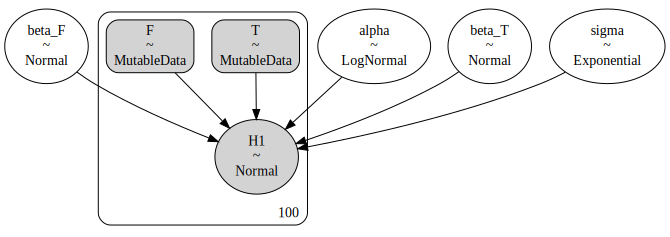

In [ ]:
with pm.Model() as biased_model:
    # Priors
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.LogNormal("alpha", 0.2)
    beta_T = pm.Normal("beta_T", 0, 0.5)
    beta_F = pm.Normal("beta_F", 0, 0.5)

    H0 = plants.H0.values
    H1 = plants.H1.values
    
    T = pm.MutableData("T", treatment.astype(float))
    F = pm.MutableData("F", fungus.astype(float))
    
    # proportional amount of growth
    g = alpha + beta_T * T + beta_F * F
    mu = g * H0
    
    # Likelihood
    pm.Normal("H1", mu, sigma, observed=H1)
    
    biased_inference = pm.sample(target_accept=.95)
    pm.compute_log_likelihood(biased_inference)
    
pm.model_to_graphviz(biased_model)

In [14]:
import seaborn as sns

<Axes: ylabel='Count'>

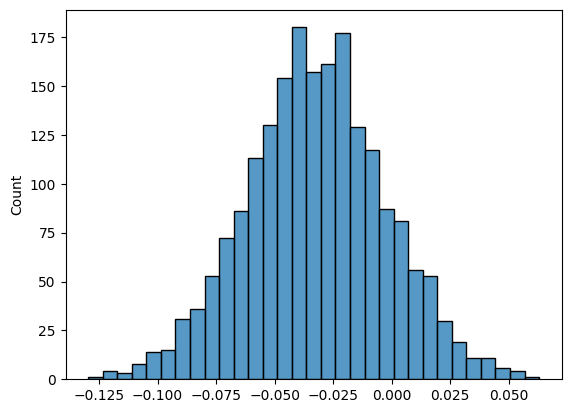

In [15]:
sns.histplot(x=biased_inference["posterior"]['beta_T'].values.reshape(-1))

In [16]:
fungus

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1], dtype=int64)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, beta_T]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 78 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


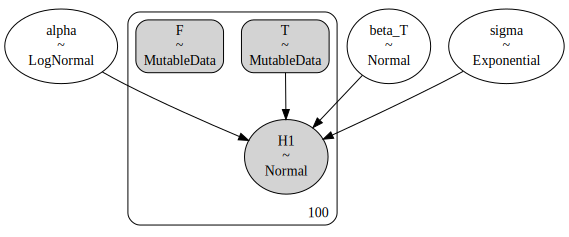

In [17]:
with pm.Model() as unbiased_model:
    # Priors
    sigma = pm.Exponential("sigma", 1.)
    alpha = pm.LogNormal("alpha", .2)
    beta_T = pm.Normal("beta_T", 0, .5)

    H0 = plants.H0.values
    H1 = plants.H1.values
    
    T = pm.MutableData("T", treatment.astype(float))
    F = pm.MutableData("F", fungus.astype(float))
    
    # proportional amount of growth
    g = alpha + beta_T * T
    mu = g * H0
    
    # Likelihood
    pm.Normal("H1", mu, sigma, observed=H1)
    
    unbiased_inference = pm.sample(target_accept=.95)
    pm.compute_log_likelihood(unbiased_inference)
    
pm.model_to_graphviz(unbiased_model)

In [18]:
comparison = az.compare(
    {
        "H1 ~ H0 + T + F": biased_inference,
        "H1 ~ H0 + T": unbiased_inference
    }, 
    scale='deviance'
)
comparison

c:\Users\Kuba\miniconda3\envs\statistical-rethinking-2023\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\Kuba\miniconda3\envs\statistical-rethinking-2023\lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
H1 ~ H0 + T + F,0,343.303968,4.046610,0.000000,1.0,15.320792,0.000000,False,deviance
H1 ~ H0 + T,1,425.353994,3.559686,82.050026,0.0,17.643679,16.953692,False,deviance


c:\Users\Kuba\miniconda3\envs\statistical-rethinking-2023\lib\site-packages\arviz\plots\backends\matplotlib\compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


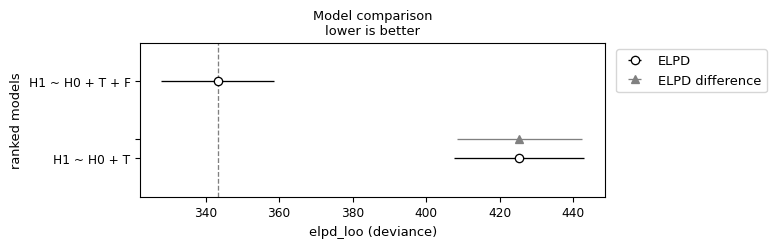

In [19]:
az.plot_compare(comparison, insample_dev=False);

<Axes: ylabel='Count'>

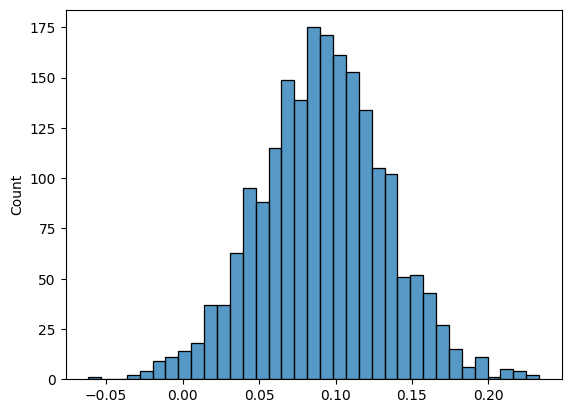

In [20]:
sns.histplot(x=unbiased_inference["posterior"]['beta_T'].values.reshape(-1))

#### DIVORCE EXAMPLE 
Outliers and how to identify them in a quantifiable way

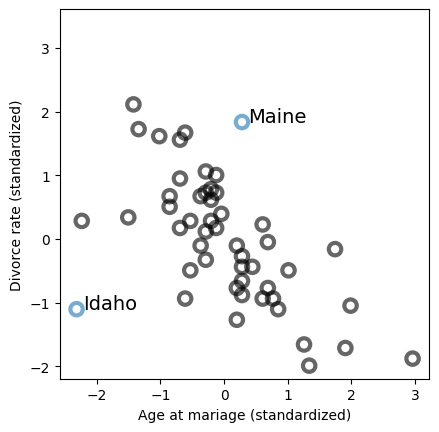

In [21]:
divorce = utils.load_data("WaffleDivorce")[["Location", "Divorce", "MedianAgeMarriage"]]

inliers_idx = divorce.query("Location not in ('Idaho', 'Maine')").index.tolist()
outliers_idx = divorce.query("Location in ('Idaho', 'Maine')").index.tolist()


std_age = utils.standardize(divorce.MedianAgeMarriage)
std_divorce = utils.standardize(divorce.Divorce)

utils.plot_scatter(std_age[inliers_idx], std_divorce[inliers_idx], color='k', label=None)
utils.plot_scatter(std_age[outliers_idx], std_divorce[outliers_idx], color='C0', label=None)

for oi in outliers_idx:
    plt.annotate(divorce.loc[oi, "Location"], (std_age[oi] + .1, std_divorce[oi]), fontsize=14)

plt.xlabel("Age at mariage (standardized)")
plt.ylabel("Divorce rate (standardized)")
plt.axis('square');

In [24]:
std_divorce

0     1.671000
1     1.560044
2     0.616916
3     2.114824
4    -0.936470
5     1.060741
6    -1.657685
7    -0.437167
8    -1.879597
9    -0.659080
10    1.005263
11   -0.770036
12   -1.102904
13   -0.936470
14    0.727872
15    0.284048
16    0.505960
17    1.615522
18    0.727872
19    1.837434
20   -0.492645
21   -1.047426
22   -0.270733
23   -1.269338
24    0.783350
25   -0.104299
26   -0.326211
27   -0.492645
28    0.228570
29   -1.990553
30    0.284048
31   -1.713163
32    0.117614
33   -0.936470
34   -0.104299
35    1.726478
36    0.395004
37   -1.102904
38   -0.159777
39   -0.880992
40    0.672394
41    0.949785
42    0.173092
43    0.284048
44   -0.048821
45   -0.437167
46    0.173092
47    0.672394
48   -0.770036
49    0.339526
Name: Divorce, dtype: float64

In [22]:
with pm.Model() as lstsq_model:
    # Priors
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 0, .5)
    beta_A = pm.Normal("beta_A", 0, .5)
    
    # Likelihood
    mu = alpha + beta_A * std_age.values
    pm.Normal("divorce", mu, sigma, observed=std_divorce.values)
    lstsq_inference = pm.sample()
    
    # required for LOOCV score
    pm.compute_log_likelihood(lstsq_inference)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, beta_A]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


c:\Users\Kuba\miniconda3\envs\statistical-rethinking-2023\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Kuba\miniconda3\envs\statistical-rethinking-2023\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


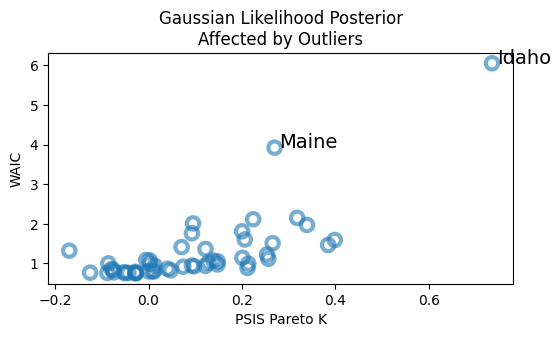

In [25]:
# Calculate Pointwise LOOCV scores
def plot_loocv(inference, title=None):
    plt.subplots(figsize=(6,3))
    pareto_k = az.loo(inference, pointwise=True).pareto_k
    waic = -az.waic(inference, pointwise=True).waic_i

    utils.plot_scatter(pareto_k, waic,  color='C0', label=None)
    for oi in outliers_idx:
        plt.annotate(divorce.loc[oi, "Location"], (pareto_k[oi] + .01, waic[oi]), fontsize=14)
    plt.xlabel("PSIS Pareto K")
    plt.ylabel("WAIC");
    plt.title(title)

plot_loocv(lstsq_inference, title="Gaussian Likelihood Posterior\nAffected by Outliers")